# Vytváření datasetu

(512, 512)
(128, 128)
(512, 512)
(128, 128)
(512, 512)
(128, 128)


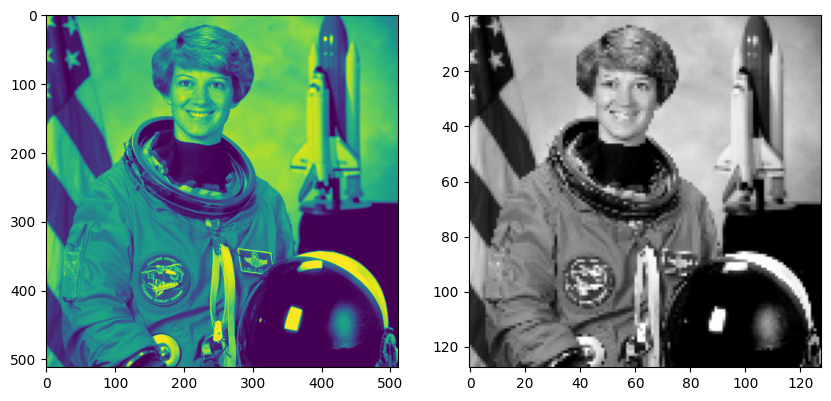

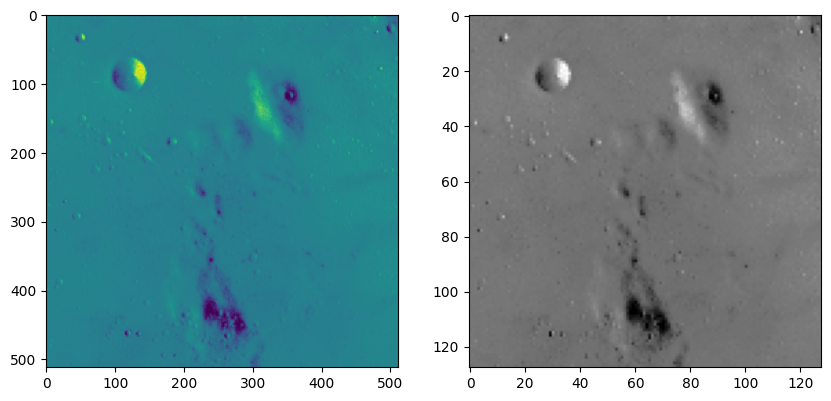

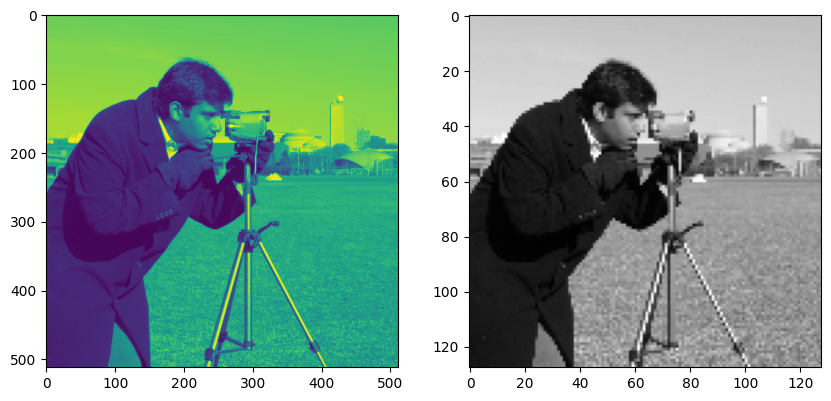

In [88]:
from skimage import data
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
import skimage
import numpy as np
import pickle

images = [rgb2gray(data.astronaut()), data.moon(), data.camera()]
processed_images = []
for image in images:
    processed_image = img_as_ubyte(image)[::4, ::4]
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    ax0.imshow(image)
    ax1.imshow(processed_image, cmap='gray')
    print(image.shape)
    print(processed_image.shape)
    processed_images.append(processed_image)


## Přidání vertikálního, diagonálního a periodického šumu

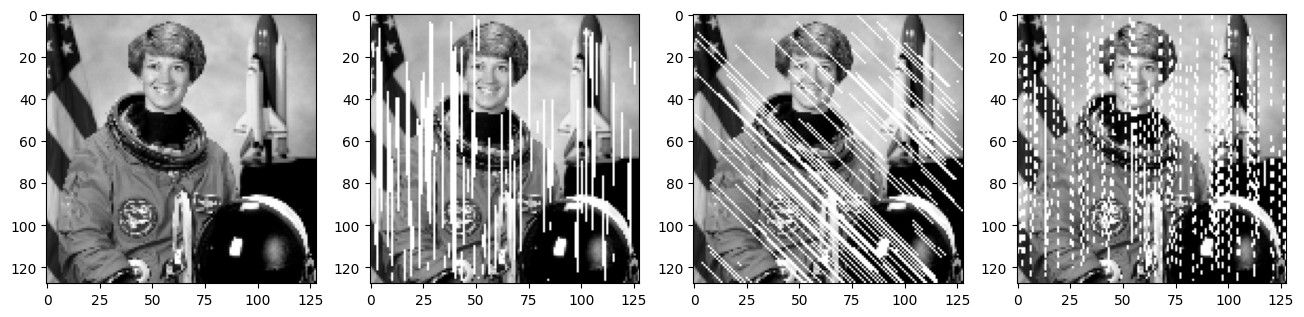

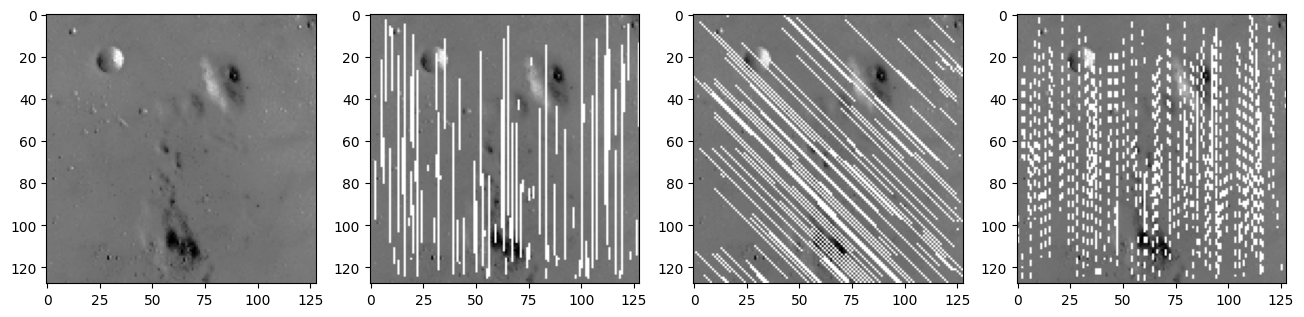

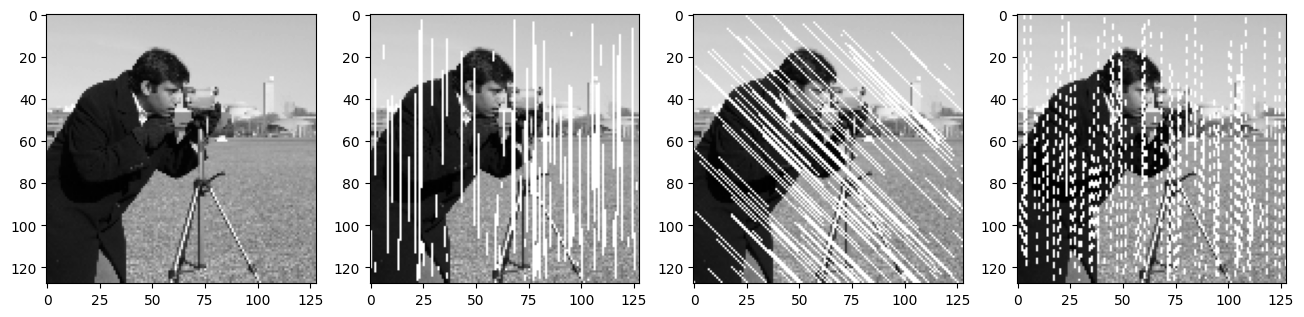

In [ ]:
def add_vertical_lines(img, percentage):
    """Add vertical lines to the image."""
    height, width = img.shape
    affected_pixels = 0
    max_affected_pixels = int(percentage * width * height)
    while affected_pixels < max_affected_pixels:
        column = np.random.randint(0, width)
        # randomly set the row from which to start the vertical line
        start_row = np.random.randint(0, height)
        end_row = np.random.randint(start_row, height)
        img[start_row:end_row, column] = 255  # set the pixel values to 255 (white)
        affected_pixels += end_row - start_row
    return img

def add_diagonal_lines(img, percentage):
    """Add diagonal lines to the image."""
    height, width = img.shape
    affected_pixels = 0
    max_affected_pixels = int(percentage * width * height)
    while affected_pixels < max_affected_pixels:
        start_col = np.random.randint(0, width) # 200
        start_row = np.random.randint(0, height) # 210
        length = np.random.randint(0, width - start_col) # 70
        clipped_length = min(min(height - start_row - 1, width - start_col - 1), length)
        end_col = clipped_length + start_col
        end_row = clipped_length + start_row
        rr, cc = skimage.draw.line(start_row, start_col, end_row, end_col)
        img[rr, cc] = 255  # set the pixel values to 255 (white)
        affected_pixels += len(rr)
    return img

def add_periodic_lines(img, percentage):
    """Add periodic vertical lines to the image."""
    height, width = img.shape
    affected_pixels = 0
    max_affected_pixels = int(percentage * width * height)
    period = 3
    while affected_pixels < max_affected_pixels:
        column = np.random.randint(0, width)
        # randomly set the row from which to start the vertical line
        start_row = np.random.randint(0, height)
        end_row = np.random.randint(start_row, height)
        # img[start_row:end_row, column,] = 255  # set the pixel values to 255 (white)
        current_row = start_row
        gap = False
        while current_row < end_row:
            current_end_row = min(current_row + period, end_row)
            if gap:
                current_row = current_end_row
                gap = False
                continue
            img[current_row:current_end_row, column] = 255  # set the pixel values to 255 (white)
            affected_pixels += current_end_row - current_row
            current_row = current_end_row
            gap = True
    return img

noise_percentage = 0.2
data = {}
dataset_names = ["astronaut", "moon", "camera"]
for processed_image, name in zip(processed_images, dataset_names):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
    ax1.imshow(processed_image, cmap='gray')
    vertical_noise_img = add_vertical_lines(processed_image.copy(), noise_percentage)
    ax2.imshow(vertical_noise_img, cmap='gray')
    diagonal_noise_img = add_diagonal_lines(processed_image.copy(), noise_percentage)
    ax3.imshow(diagonal_noise_img, cmap='gray')
    periodic_noise_img = add_periodic_lines(processed_image.copy(), noise_percentage)
    ax4.imshow(periodic_noise_img, cmap='gray')
    data["name"] = {
        "name": name,
        "noise_percentage": noise_percentage,
        "image_shape": processed_image.shape,
        "image_type": "grayscale",
        "original": processed_image,
        "vertical_noise": vertical_noise_img,
        "diagonal_noise": diagonal_noise_img,
        "periodic_noise": periodic_noise_img
    }
    plt.show()

pickle.dump(data, open("datasets/dataset.pkl", "wb"))
